In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from pathlib import Path
import cv2 as cv
import scipy

In [2]:
def check_jpg_counts(path):
    cnt = 0
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if os.path.isdir(dir_path):
            jpg_count = sum(1 for f in os.listdir(dir_path) if f.endswith(".jpg"))
            if jpg_count != 170:
                print(f"file {dir_name} has {jpg_count} number .jpg")
            cnt += jpg_count
    print('other files each 170 number .jpg')
    print(f"total {cnt} number .jpg")


# check the number of .jpg files in each directory
_dataset_dir = "./data/PIE"
check_jpg_counts(_dataset_dir)

file 38 has 164 number .jpg
other files each 170 number .jpg
total 11554 number .jpg


In [3]:
test_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # change own image to 1 channel
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


class FaceDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FaceDataset, self).__init__()
        self.path = path
        self.files = self._get_all_files(path) if files is None else files
        if len(self.files) == 0:
            raise ValueError(f"No .jpg files found in {path}")
        print(f"One {path} sample", self.files[0])
        self.transform = tfm

    def _get_all_files(self, path):
        """Recursively get all jpg files."""
        file_list = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg'):
                    file_list.append(os.path.join(root, file))
        return sorted(file_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        if self.transform:
            im = self.transform(im)
        try:
            label = int(fname.split("/")[-2])  # adjusted to get the parent directory as label
        except:
            label = -1  # test has no label
        return im, label

In [4]:
seed = 202311172359
num_subject = 25
subjects_index = np.random.default_rng(seed).choice(np.arange(1, 69), num_subject, replace=False)

image_data = []
label_data = []

directory = Path("../ca2/data/PIE")
for i in subjects_index:
    images_folder = []
    labels_folder = []
    sub_file = directory / str(i)

    files = list(sub_file.glob("*.jpg"))
    np.random.default_rng(seed).shuffle(files)
    for filename in files:
        image0 = Image.open(filename)
        images_folder.append(np.array(image0))
        labels_folder.append(i)
    image_data.append(images_folder)
    label_data.append(labels_folder)

print(subjects_index)

[18 46 32 42  6 15 33 64 23 39  7 54 53 28 58 11  3 17 52  2 67 49 20 66
 50]


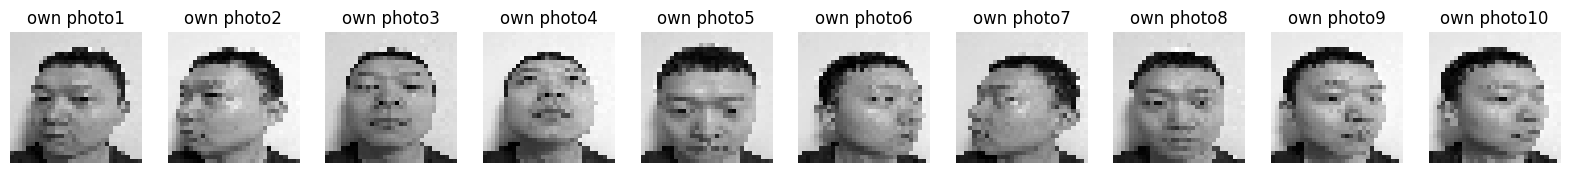

In [5]:
own_image_data = []
own_label_data = []

for i in range(1, 10 + 1):
    img = cv.imread('../ca2/data/own/69/' + str(i) + '.jpg', cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (32, 32), interpolation=cv.INTER_CUBIC)
    own_image_data.append(img)
    own_label_data.append(69)

# train, test split, rate 7:3
own_train_image_data = own_image_data[0:7]
own_test_image_data = own_image_data[7:]
own_train_label_data = own_label_data[0:7]
own_test_label_data = own_label_data[7:]

fig = plt.figure(figsize=(20, 10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_image_data[i - 1], cmap='gray')
    plt.title('own photo' + str(i))
    plt.axis('off')

plt.show()

In [6]:
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(0.7 * 170))

image_data_train, image_data_test = np.split(np.array(image_data), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
label_data_train, label_data_test = np.split(np.array(label_data), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
own_image_data_train, own_image_data_test = np.split(np.array(own_image_data), [7])
own_label_data_train, own_labels_data_test = np.split(np.array(own_label_data), [7])

import warnings
# ignore warnings for this part
warnings.filterwarnings('ignore', category=Warning)

# reshape data
main_image_data_train = image_data_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT, 1024)
own_image_data_train = own_image_data_train.reshape(7, 1024)
image_data_test = image_data_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT), 1024)
own_image_data_test = own_image_data_test.reshape(3, 1024)

label_data_train = label_data_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT)
label_data_test = label_data_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT))

# Combine PIE images and own photos to get full train and test sets
full_train_image_set = np.append(main_image_data_train, own_image_data_train, axis=0, )
full_train_label_set = np.append(label_data_train, own_label_data_train)

full_test_image_set = np.append(image_data_test, own_image_data_test, axis=0, )
full_test_label_set = np.append(label_data_test, own_labels_data_test)

In [7]:
# full data set
X_train = full_train_image_set
y_train = full_train_label_set

In [8]:
X_mean = np.mean(X_train, axis=0)
X_norm = X_train - X_mean

u, s, vt = np.linalg.svd(X_norm, full_matrices=False)
s_diag = np.diag(s)

# max components: 200
X_pca = u[:, :200] @ s_diag[:200, :200]
X_test_mean = np.mean(full_test_image_set, axis=0)
X_test_norm = full_test_image_set - X_test_mean
# projection for test set
projected_X_pca_test = X_test_norm @ vt.T[:, :200]
projected_own_X_pca_test = (own_image_data_test - X_mean) @ vt.T[:, :200]

In [9]:
from libsvm.python.libsvm.svmutil import *
from libsvm.python.libsvm.svm import *


def svm(X, y, raw):
    def svm_c(c, prob, raw):
        print("For penalty parameter C = " + str(c) + ":")
        param = svm_parameter("-t 0 -c " + str(c) + " -q")
        m = svm_train(prob, param)
        if raw:
            p_label, p_acc, p_val = svm_predict(full_test_label_set, full_test_image_set, m)
        else:
            p_label, p_acc, p_val = svm_predict(full_test_label_set, projected_X_pca_test, m)
        print("Accuracy = " + str(p_acc[0]) + "%")

    prob = svm_problem(y, X)
    # Vary C
    svm_c(1e-2, prob, raw)
    svm_c(1e-1, prob, raw)
    svm_c(1, prob, raw)


# create custom function
def compute_display_svm(train_data, train_labels, test_data, test_labels, n_pc=3,
                        svm_settings='-t 0 -c 1e-2', set_name="ALL"):
    # reduce dimensionality of vectorized images to n_pc
    # clf = classifier(n_components=n_pc)
    # clf.fit(train_data)

    # project train and test data into n_pc-d
    if n_pc is None:
        train_x_clf_nd = train_data
        test_x_clf_nd = test_data
        own_test = projected_own_X_pca_test[:, :n_pc]
    else:
        train_x_clf_nd = X_pca[:, :n_pc]
        test_x_clf_nd = projected_X_pca_test[:, :n_pc]
        own_test = projected_own_X_pca_test[:, :n_pc]
    # perform classification
    svm_model = svm_train(train_labels, train_x_clf_nd, svm_settings)
    test_pred, p_acc, p_val = svm_predict(test_labels, test_x_clf_nd, svm_model)
    to, opa, opv = svm_predict(own_labels_data_test, own_test, svm_model)

    # calculate accuracy
    print('Accuracy of SVM with {}-components for {} test set: {}%'.format(
        n_pc, set_name, round(p_acc[0], 3)))
    print('Accuracy of SVM with {}-components for own test set: {}%'.format(
        n_pc, round(opa[0], 3)))

In [10]:
def svm_test(svm_setting = '-t 0 -c 1 -q'):
    print(f'setting: {svm_setting}')
    compute_display_svm(X_train, y_train, full_test_image_set, full_test_label_set, n_pc=None,
                        svm_settings=svm_setting)
    compute_display_svm(X_train, y_train, full_test_image_set, full_test_label_set, n_pc=80,
                        svm_settings=svm_setting)
    compute_display_svm(X_train, y_train, full_test_image_set, full_test_label_set, n_pc=200,
                        svm_settings=svm_setting)

In [11]:
# y = y_train
# x = X_train
# prob  = svm_problem(y, x)
# param = svm_parameter('-t 0 -c 1e-1 -q')
# model = svm_train(prob, param)
# yt = full_test_label_set
# xt = full_test_image_set
# p_label, p_acc, p_val = svm_predict(yt, xt, model)
# # print(calculate_accuracy(p_label, true_labels))

In [12]:
svm_test()

setting: -t 0 -c 1 -q
Accuracy = 99.2175% (1268/1278) (classification)
Accuracy = 0% (0/3) (classification)
Accuracy of SVM with None-components for ALL test set: 99.218%
Accuracy of SVM with None-components for own test set: 0.0%
Accuracy = 99.1393% (1267/1278) (classification)
Accuracy = 100% (3/3) (classification)
Accuracy of SVM with 80-components for ALL test set: 99.139%
Accuracy of SVM with 80-components for own test set: 100.0%
Accuracy = 99.2958% (1269/1278) (classification)
Accuracy = 100% (3/3) (classification)
Accuracy of SVM with 200-components for ALL test set: 99.296%
Accuracy of SVM with 200-components for own test set: 100.0%


In [13]:
svm_test('-t 0 -c 1e-1 -q')

setting: -t 0 -c 1e-1 -q
Accuracy = 99.2175% (1268/1278) (classification)
Accuracy = 0% (0/3) (classification)
Accuracy of SVM with None-components for ALL test set: 99.218%
Accuracy of SVM with None-components for own test set: 0.0%
Accuracy = 99.1393% (1267/1278) (classification)
Accuracy = 100% (3/3) (classification)
Accuracy of SVM with 80-components for ALL test set: 99.139%
Accuracy of SVM with 80-components for own test set: 100.0%
Accuracy = 99.2958% (1269/1278) (classification)
Accuracy = 100% (3/3) (classification)
Accuracy of SVM with 200-components for ALL test set: 99.296%
Accuracy of SVM with 200-components for own test set: 100.0%


In [14]:
svm_test('-t 0 -c 1e-2 -q')

setting: -t 0 -c 1e-2 -q
Accuracy = 99.2175% (1268/1278) (classification)
Accuracy = 0% (0/3) (classification)
Accuracy of SVM with None-components for ALL test set: 99.218%
Accuracy of SVM with None-components for own test set: 0.0%
Accuracy = 99.1393% (1267/1278) (classification)
Accuracy = 100% (3/3) (classification)
Accuracy of SVM with 80-components for ALL test set: 99.139%
Accuracy of SVM with 80-components for own test set: 100.0%
Accuracy = 99.2958% (1269/1278) (classification)
Accuracy = 100% (3/3) (classification)
Accuracy of SVM with 200-components for ALL test set: 99.296%
Accuracy of SVM with 200-components for own test set: 100.0%


In [15]:
svm_test('-t 0 -c 1e-8 -q')

setting: -t 0 -c 1e-8 -q
Accuracy = 39.2019% (501/1278) (classification)
Accuracy = 0% (0/3) (classification)
Accuracy of SVM with None-components for ALL test set: 39.202%
Accuracy of SVM with None-components for own test set: 0.0%
Accuracy = 35.759% (457/1278) (classification)
Accuracy = 0% (0/3) (classification)
Accuracy of SVM with 80-components for ALL test set: 35.759%
Accuracy of SVM with 80-components for own test set: 0.0%
Accuracy = 35.9937% (460/1278) (classification)
Accuracy = 0% (0/3) (classification)
Accuracy of SVM with 200-components for ALL test set: 35.994%
Accuracy of SVM with 200-components for own test set: 0.0%


In [16]:
print("Use raw face images (vectorized):")
svm(X_train, y_train, True)

Use raw face images (vectorized):
For penalty parameter C = 0.01:
Accuracy = 99.2175% (1268/1278) (classification)
Accuracy = 99.21752738654148%
For penalty parameter C = 0.1:
Accuracy = 99.2175% (1268/1278) (classification)
Accuracy = 99.21752738654148%
For penalty parameter C = 1:
Accuracy = 99.2175% (1268/1278) (classification)
Accuracy = 99.21752738654148%


In [17]:
print("Use face vectors after PCA pre-processing with dimensionality of 80: ")
svm(X_pca[:, :80], y_train, False)

Use face vectors after PCA pre-processing with dimensionality of 80: 
For penalty parameter C = 0.01:
Accuracy = 99.1393% (1267/1278) (classification)
Accuracy = 99.13928012519561%
For penalty parameter C = 0.1:
Accuracy = 99.1393% (1267/1278) (classification)
Accuracy = 99.13928012519561%
For penalty parameter C = 1:
Accuracy = 99.1393% (1267/1278) (classification)
Accuracy = 99.13928012519561%


In [18]:
print("Use face vectors after PCA pre-processing with dimensionality of 200: ")
svm(X_pca[:, :200], y_train, False)

Use face vectors after PCA pre-processing with dimensionality of 200: 
For penalty parameter C = 0.01:
Accuracy = 99.2958% (1269/1278) (classification)
Accuracy = 99.29577464788733%
For penalty parameter C = 0.1:
Accuracy = 99.2958% (1269/1278) (classification)
Accuracy = 99.29577464788733%
For penalty parameter C = 1:
Accuracy = 99.2958% (1269/1278) (classification)
Accuracy = 99.29577464788733%
